In [19]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.fit_model as fit_model

import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"



class EPIS_dense():
    def __init__(self, ISNet, psMatrices, populations, firstTS, device="cpu", train=False, cc=None, recursive=False):
        self._n= ISNet.size()[0]
        self._models= []
        self._numVirus= len(psMatrices)
        for i in range(self._numVirus):
            model= fit_model.EPI_dense( ISNet, psMatrices[i], populations[i], device, train=train, cc=cc, recursive=recursive)
            self._models.append(model)
        self._firstTS= firstTS
        self._train= train
        self._t= 0
    def inference(self):
        self._t+=1
        exceptions= []
        probabilities= []
        statisticI= torch.zeros(self._n).to(device)
        for i in range(self._numVirus):
            if self._firstTS[i]>self._t:
                expectation= self._models[i].get_population_num()
                probability= expectation*0
            else:
                expectation, probability= self._models[i].forward()
            state= self._models[i].get_population()
            statisticI= torch.logical_or(state[2, :], statisticI)
            exceptions.append(expectation)
            probabilities.append(probability)
        exceptions= torch.stack(exceptions)
        probabilities= torch.stack(probabilities)
        return exceptions, probabilities, statisticI.sum(dim=0)
        

In [20]:
def sim(timeHorizon, model: EPIS_dense):
  populationNumbers= []
  populationExpectations= []
  statisticInfecteds=[]
  for i in range(timeHorizon):
    populationNumber, populationExpectation, statisticI= model.inference()
    populationNumbers.append(populationNumber)
    populationExpectations.append(populationExpectation)
    statisticInfecteds.append(statisticI)

  populationNumbers = torch.stack(populationNumbers)
  populationExpectations = torch.stack(populationExpectations)
  statisticInfecteds = torch.stack(statisticInfecteds)

  return populationNumbers, populationExpectations, statisticInfecteds

In [102]:
n= 2000
avgDegree= 10
timeHorizon= 365
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps1= torch.tensor([[0, 0.02, 0, 0],
                      [0, 0, 0.5, 0],
                      [0, 0, 0, 0.02],
                      [0, 0, 0, 0]], device=device)
    ps2= torch.tensor([[0, 0.1, 0, 0],
                      [0, 0, 0.6, 0],
                      [0, 0, 0, 0.2],
                      [0, 0, 0, 0]], device=device)
    pss= [ps1,ps2]
    firstTs= [1, 200]
    populations= create_population.populations(n, 2, device)
    model= EPIS_dense(contact, pss, populations, firstTs, device)
    realData, _, statisticInfecteds =sim(timeHorizon, model)
    realData= realData.sum(dim=1)
    print(realData.shape)


torch.Size([365, 4])


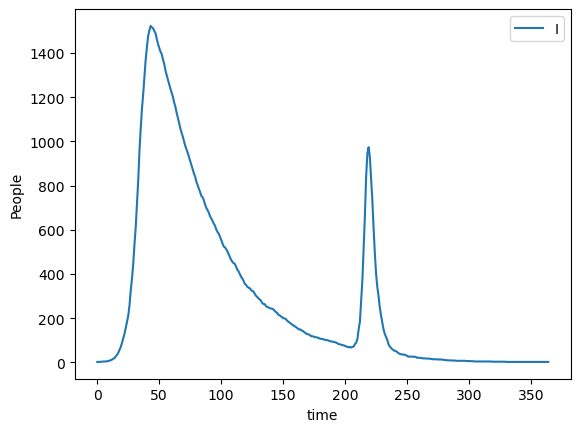

In [103]:
populationNumberPlot= realData.cpu().detach()
statisticInfectedsPlot= statisticInfecteds.cpu().detach()
plt.plot(statisticInfectedsPlot, label='I')
#plt.plot(populationNumberPlot[:, 2], label="I2")
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

In [19]:
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
cc= torch.tensor([  [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0]], device=device)
populationFit= create_population.population(n, device)
modelFit= fit_model.EPI_dense(contact, psFit, populationFit, device, train=True, cc=cc, recursive=True)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)

In [20]:
fitPinfs=[]
#1. choose a better optimiser
#2. bigmodel learn intrinsic, gradient easy model !!!
#3. adaptive constraint?
#4. GAN ?
losses= []
for i in tqdm(range(500)):
    optimizer.zero_grad()
    fitPinfs.append(modelFit.get_psMatrix())
    populationFit= create_population.population(n, device)
    modelFit.reset_population(populationFit)
    fitPopulation, expectation = sim(timeHorizon, modelFit)
    #loss= lossFn(expectation, realData)/n/timeHorizon
    loss= lossFn(expectation[:, 2], realData[:, 2])/n/timeHorizon
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrix())

100%|██████████| 500/500 [00:59<00:00,  8.42it/s]

tensor([[0.0000, 0.2235, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6083, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0896],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


tensor([[0.0000, 0.2235, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6083, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0896],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


Text(0, 0.5, 'loss')

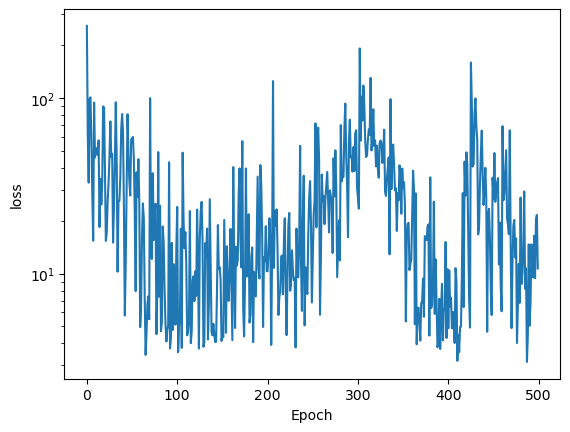

In [21]:
print(modelFit.get_psMatrix())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [22]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.0733, -0.0733,  0.0733,  0.0733],
        [-0.7694, -0.7694,  0.7694, -0.7694],
        [ 0.6097,  0.6097,  0.6097, -0.6097],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[-0.3180,  0.9539, -0.3180, -0.3180],
        [-3.3450, -3.3450, 10.0349, -3.3450],
        [ 1.3926,  1.3926,  1.3926, -4.1778],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
---------------------------------


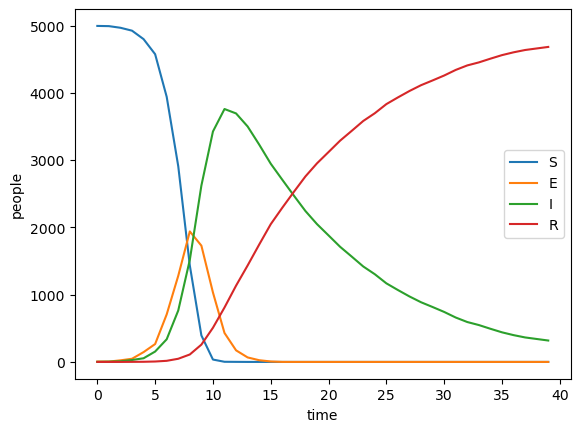

In [23]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("people")
plt.legend()